# Predicting CAN Bus Intrusion Using Machine Learning

This notebook explores the use of machine learning and Python-based data science libraries to build a model capable of detecting intrusions in in-vehicle CAN (Controller Area Network) communication based on message patterns and timing.

We will take the following approach:

1. **Problem Definition**  
2. **Data**  
3. **Evaluation**  
4. **Features**  
5. **Modelling**  
6. **Experimentation**

---

##  1. Problem Definition

In a single sentence:

> Given CAN bus communication parameters such as timestamp, arbitration ID, and data values, can we predict whether or not a message is part of a cyberattack on the vehicle?


##  2. Data

The dataset was collected from a **KIA SOUL** vehicle via the **OBD-II port** while performing both normal and malicious activities on the CAN bus. It includes the following four states:

1. **DoS Attack** – Repeatedly injecting messages with CAN ID `0x000`
2. **Fuzzy Attack** – Injecting messages with random CAN IDs and data
3. **Impersonation Attack** – Injecting spoofed messages using CAN ID `0x164`
4. **Attack-Free State** – Normal CAN communication

Each record in the dataset contains:

- `Timestamp`: Time in seconds  
- `CAN ID`: Identifier of the message (hexadecimal)  
- `DLC`: Number of data bytes (0 to 8)  
- `DATA[0-7]`: Payload bytes of the CAN message  

The dataset is available for research purposes and was originally used in the **2017 Information Security R&D dataset challenge** in South Korea.

🔗 [IEEE Paper Link](https://ieeexplore.ieee.org/document/8476919)

---

## 3. Evaluation

Our goal is to build a machine learning model that can detect CAN bus intrusions in real-time.  

If the model achieves a detection **accuracy of 90% or higher**, especially in distinguishing between attack and normal states, we will consider the solution effective for practical use.


## 4. Features

This section describes the key features (columns) in the CAN bus dataset. These attributes are derived from in-vehicle communication logs recorded during normal and attack scenarios.

###  Data Dictionary

| Feature       | Description |
|---------------|-------------|
| `Timestamp`   | Time when the CAN message was recorded (in seconds). Useful for computing message frequency, time intervals, or offset ratio. |
| `CAN ID`      | Arbitration ID of the CAN message, represented in hexadecimal (e.g., `0x164`). Can be used to distinguish between different Electronic Control Units (ECUs). |
| `DLC`         | Data Length Code – number of bytes in the message payload (0 to 8). |
| `DATA[0-7]`   | The payload bytes (up to 8) of the CAN message. These bytes may contain status, sensor readings, or control commands. |
| `Label`       | Indicates whether the message is part of an attack or not (only labeled in DoS). In some attack types (like fuzzy or impersonation), the attack window is known (e.g., after 250s), but individual message labels are not provided. |

---

###  Note:
- In DoS attacks, all messages with `CAN ID = 0x000` are considered **abnormal**.
- In fuzzy and impersonation attacks, there are no explicit per-row labels; however, we can infer attacks based on **time windows**.
- Timing-related features like **offset ratio** and **response delay** can be engineered for advanced detection.

---

To improve detection performance, we'll also create derived features such as:
- Message frequency per ID
- Time delta between identical IDs
- Bit-level entropy or data variation
- Offset timing between request and response frames


In [134]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [80]:
import re
import pandas as pd

# Prepare to store a sample of lines
sample_size = 100000
data = []

# Regex pattern for the lines
pattern = re.compile(
    r"Timestamp:\s+([0-9.]+)\s+ID:\s+([0-9A-Fa-f]+)\s+\d+\s+DLC:\s+(\d+)\s+((?:[0-9A-Fa-f]{2}\s+){1,8})"
)

with open("data/Attack_free_dataset.txt") as f:
    for i, line in enumerate(f):
        if i >= sample_size:
            break

        match = pattern.search(line)
        if match:
            timestamp = float(match.group(1))
            can_id = int(match.group(2), 16)
            dlc = int(match.group(3))
            data_bytes = [int(b, 16) for b in match.group(4).strip().split()]
            # Pad to 8 bytes if less (e.g., DLC = 4)
            while len(data_bytes) < 8:
                data_bytes.append(0)
            row = [timestamp, can_id, dlc] + data_bytes[:8] + [0]
            data.append(row)


In [81]:
columns = ['Timestamp', 'CAN ID', 'DLC'] + [f'DATA[{i}]' for i in range(8)] + ['Label']
df = pd.DataFrame(data, columns=columns)
df.to_csv("data/attack_free_sample.csv", index=False)


In [82]:
df1 = pd.read_csv("data/attack_free_sample.csv")
df.head()

,Timestamp,CAN ID,DLC,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label
0,0.000000,790,8,5,32,234,10,32,26,0,127,0
1,0.000224,809,8,215,167,127,140,17,47,0,16,0
2,0.000462,128,8,0,23,234,10,32,26,32,67,0
3,0.000704,129,8,127,132,96,0,0,0,0,83,0
4,0.000878,288,4,0,0,0,0,0,0,0,0,0


In [83]:
df1.isna().sum()

Timestamp    0
CAN ID       0
DLC          0
DATA[0]      0
DATA[1]      0
DATA[2]      0
DATA[3]      0
DATA[4]      0
DATA[5]      0
DATA[6]      0
DATA[7]      0
Label        0
dtype: int64

In [84]:
df1["Label"].value_counts()

Label
0    95746
Name: count, dtype: int64

In [85]:
df1.columns = ['Timestamp', 'ID', 'DLC', 
               'Byte1', 'Byte2', 'Byte3', 'Byte4',
               'Byte5', 'Byte6', 'Byte7', 'Byte8', 'Label']

In [93]:

df1.to_csv('data/attack_free_sample_new.csv', index=False)
df1 = pd.read_csv("data/attack_free_sample_new.csv")

In [94]:
df1.head()

,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,0.000000,790,8,5,32,234,10,32,26,0,127,0
1,0.000224,809,8,215,167,127,140,17,47,0,16,0
2,0.000462,128,8,0,23,234,10,32,26,32,67,0
3,0.000704,129,8,127,132,96,0,0,0,0,83,0
4,0.000878,288,4,0,0,0,0,0,0,0,0,0


In [95]:
import re
import pandas as pd

# Example: use this if you've copied the raw text to a file
with open("data/Impersonation_attack_dataset.txt", "r") as f:
    lines = f.readlines()

rows = []

for line in lines:
    match = re.match(
        r"Timestamp:\s+([\d.]+)\s+ID:\s+([0-9a-fA-F]+)\s+\d+\s+DLC:\s+(\d+)\s+((?:[0-9a-fA-F]{2}[\s]+){1,8})",
        line
    )
    if match:
        timestamp = float(match.group(1))
        can_id = match.group(2)
        dlc = int(match.group(3))
        data_bytes = match.group(4).strip().split()

        # Pad if < 8 bytes
        while len(data_bytes) < 8:
            data_bytes.append("00")

        rows.append([timestamp, can_id, dlc] + data_bytes[:8] + [1])  # Label = 1

# Define column names
cols = ["Timestamp", "ID", "DLC"] + [f"Byte{i}" for i in range(1, 9)] + ["Label"]

# Create DataFrame
df = pd.DataFrame(rows, columns=cols)


In [96]:
df.head()

,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.481193e+09,0587,8,00,00,00,00,00,00,00,01,1
1,1.481193e+09,0316,8,05,1c,6a,0a,1c,13,00,7f,1
2,1.481193e+09,018f,8,00,21,1c,00,00,43,00,00,1
3,1.481193e+09,0260,8,05,1c,00,30,ff,93,63,35,1
4,1.481193e+09,0080,8,00,17,6a,0a,1c,13,1c,1f,1


In [97]:
df.to_csv("data/Impersonation_attack_dataset_sample.csv")


In [98]:
df2 = pd.read_csv("data/Impersonation_attack_dataset_sample.csv")
df.head()

,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.481193e+09,0587,8,00,00,00,00,00,00,00,01,1
1,1.481193e+09,0316,8,05,1c,6a,0a,1c,13,00,7f,1
2,1.481193e+09,018f,8,00,21,1c,00,00,43,00,00,1
3,1.481193e+09,0260,8,05,1c,00,30,ff,93,63,35,1
4,1.481193e+09,0080,8,00,17,6a,0a,1c,13,1c,1f,1


In [99]:
df2 = df2.drop('Unnamed: 0', axis=1)
df2.head()

,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.481193e+09,0587,8,00,00,00,00,00,00,00,01,1
1,1.481193e+09,0316,8,05,1c,6a,0a,1c,13,00,7f,1
2,1.481193e+09,018f,8,00,21,1c,00,00,43,00,00,1
3,1.481193e+09,0260,8,05,1c,00,30,ff,93,63,35,1
4,1.481193e+09,0080,8,00,17,6a,0a,1c,13,1c,1f,1


In [101]:
import pandas as pd

# Load both CSV files
df1 = pd.read_csv('data/Impersonation_attack_dataset_sample.csv')
df2 = pd.read_csv('data/attack_free_sample_new.csv')

# Optional: Drop 'Unnamed: 0' if present
df1 = df1.drop('Unnamed: 0', axis=1, errors='ignore')
df2 = df2.drop('Unnamed: 0', axis=1, errors='ignore')

# Optional: Rename columns (ensure both DataFrames have same column names)
df1.columns = ['Timestamp', 'ID', 'DLC', 'Byte1','Byte2','Byte3','Byte4','Byte5','Byte6','Byte7','Byte8','Label']
df2.columns = df1.columns  # assumes same structure

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Save to new CSV
df_combined.to_csv('data/combined.csv', index=False)


In [102]:
df3= pd.read_csv('data/combined.csv')
df3.head()

/var/folders/r4/bpr7f5dn7yb8kmnyhqbv7zjr0000gn/T/ipykernel_19843/4143382520.py:1: DtypeWarning: Columns (1,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df3= pd.read_csv('data/combined.csv')


,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.481193e+09,0587,8,00,00,00,00,00,00,00,01,1
1,1.481193e+09,0316,8,05,1c,6a,0a,1c,13,00,7f,1
2,1.481193e+09,018f,8,00,21,1c,00,00,43,00,00,1
3,1.481193e+09,0260,8,05,1c,00,30,ff,93,63,35,1
4,1.481193e+09,0080,8,00,17,6a,0a,1c,13,1c,1f,1


In [105]:
df3.isna().sum()

Timestamp    0
ID           0
DLC          0
Byte1        0
Byte2        0
Byte3        0
Byte4        0
Byte5        0
Byte6        0
Byte7        0
Byte8        0
Label        0
dtype: int64

In [108]:
df3["Label"].value_counts()

Label
1    995472
0     95746
Name: count, dtype: int64

In [111]:
# Downsample df1 (Label 0) to match df2 (Label 1)
df1_down = df1.sample(n=len(df2), random_state=42)

# Combine the balanced dataset
df_balanced = pd.concat([df1_down, df2], ignore_index=True)

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
df_balanced.to_csv('data/balanced.csv', index=False)


In [114]:
df3 = pd.read_csv('data/balanced.csv')

In [121]:
df3.head()

,Timestamp,ID,DLC,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.481193e+09,0153,8,00,80,10,ff,00,ff,e0,6e,1
1,1.481193e+09,018f,8,00,23,18,00,00,3f,00,00,1
2,1.481193e+09,02b0,5,74,00,00,07,37,00,00,00,1
3,1.481193e+09,0080,8,00,17,c0,09,19,11,19,fe,1
4,1.481193e+09,0260,8,05,1a,00,30,ff,90,5f,11,1


In [126]:
df3['DLC'].value_counts()

DLC
8    179781
5      8939
4      1427
3       909
2       436
Name: count, dtype: int64

In [118]:
#finally the combined data is ready yay

In [119]:
print(df_balanced.isnull().sum())

Timestamp    0
ID           0
DLC          0
Byte1        0
Byte2        0
Byte3        0
Byte4        0
Byte5        0
Byte6        0
Byte7        0
Byte8        0
Label        0
dtype: int64


In [136]:
byte_cols = ['Byte1','Byte2','Byte3','Byte4','Byte5','Byte6','Byte7','Byte8']

for col in byte_cols:
    df_balanced[col] = df_balanced[col].apply(lambda x: int(str(x), 16))


In [137]:
df_balanced = df_balanced.drop(['Timestamp', 'ID', 'DLC'], axis=1)


In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_balanced[byte_cols] = scaler.fit_transform(df_balanced[byte_cols])


In [139]:
X = df_balanced.drop('Label', axis=1)
y = df_balanced['Label']


In [140]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
 


In [141]:
svm = SVC()
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000)

# Fit models
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [142]:
y_pred_svm = svm.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test)

In [143]:
from sklearn.metrics import classification_report, confusion_matrix

print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

SVM:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     19150
           1       0.83      1.00      0.91     19149

    accuracy                           0.90     38299
   macro avg       0.92      0.90      0.90     38299
weighted avg       0.92      0.90      0.90     38299

Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     19150
           1       0.98      0.94      0.96     19149

    accuracy                           0.96     38299
   macro avg       0.96      0.96      0.96     38299
weighted avg       0.96      0.96      0.96     38299

Logistic Regression:
               precision    recall  f1-score   support

           0       0.90      0.69      0.78     19150
           1       0.75      0.92      0.83     19149

    accuracy                           0.81     38299
   macro avg       0.82      0.81      0.80     38299
weighted avg       0.82      0

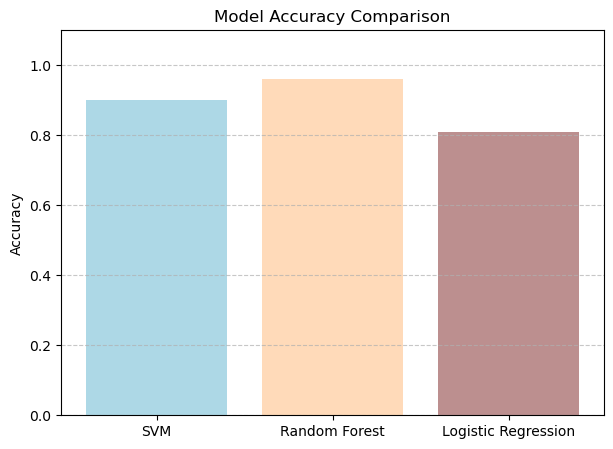

In [159]:
import matplotlib.pyplot as plt

# models
models = ['SVM', 'Random Forest', 'Logistic Regression']

# Example metric: Accuracy 
accuracy_scores = [0.90, 0.96, 0.81]


plt.figure(figsize=(7, 5))
bars = plt.bar(models, accuracy_scores, color=['lightblue', 'peachpuff', 'rosybrown'])


plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
